# Feature Engineering Notebook
The primary purpose of this  notebook is to prepare and transform the dataset for an LSTM model that aims to predict wholesale and retail prices in various markets. 

This preparation includes extracting time-based features to capture seasonal and trend patterns, creating lag and rolling window features to integrate historical price data and short-term trends

Additionally, the notebook encompasses correlation analysis to identify influential predictors, categorical feature encoding for nominal data, and normalization or standardization of features to optimize LSTM model performance. 

This systematic approach, guided by insights from the EDA, ensures that the dataset is optimally structured for time series forecasting, facilitating the development of an accurate and robust predictive model. 

The notebook not only serves as a practical tool for data transformation but also as a documented reference outlining the rationale and methodology behind each feature engineering decision, setting a strong foundation for the predictive modeling phase of the project.

In [99]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
import joblib
from joblib import dump
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from math import sqrt
import numpy as np
import scipy.stats as stats
import category_encoders as ce
import os


In [100]:
data = pd.read_csv("clean_data2.csv")

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20431 entries, 0 to 20430
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Classification  20431 non-null  object 
 1   Market          20431 non-null  object 
 2   Wholesale       20431 non-null  float64
 3   Retail          20431 non-null  float64
 4   Supply Volume   20431 non-null  float64
 5   County          20431 non-null  object 
 6   Date            20431 non-null  object 
dtypes: float64(3), object(4)
memory usage: 1.1+ MB



### Date Conversion and Feature Extraction in Maize Price Prediction Model

In our maize price prediction model, the 'Date' column contains crucial information that can significantly impact the accuracy of the predictions. To leverage this, we performed the following steps:

#### 1. Conversion of 'Date' to Datetime Format

 Converting the 'Date' column to a proper datetime format allows us to extract various time-related features that might influence price trends. It ensures the 'Date' is interpreted correctly for further analysis and manipulation.

#### 2. Extraction of Time Features
Year, Month, Day: These features help identify the specific point in time when the prices were recorded, which is crucial for modeling seasonality and understanding long-term price trends. For example, prices might vary across different years or months due to harvesting cycles, supply chain factors, or demand fluctuations.

DayOfWeek: This feature is added to capture potential patterns in price changes depending on the day of the week. For instance, maize prices might fluctuate depending on market activity, which could differ between weekdays and weekends.

Quarter: Including the quarter feature allows the model to detect broader seasonal trends, as maize prices could vary between quarters due to seasonal agricultural activities like planting and harvesting

In [102]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Extracting time features
data['Year'] = data['Date'].dt.year # Year
data['Month'] = data['Date'].dt.month # Month of the year
data['Day'] = data['Date'].dt.day # Day of the month
data['DayOfWeek'] = data['Date'].dt.dayofweek # Monday=0, Sunday=6
data['Quarter'] = data['Date'].dt.quarter # Quarter of the year

# Display the results
data.head()

,Classification,Market,Wholesale,Retail,Supply Volume,County,Date,Year,Month,Day,DayOfWeek,Quarter
0,Mixed-Traditional,Eldama Ravine,31.288,40.0,2650.0,Baringo,2021-05-24,2021,5,24,0,2
1,Mixed-Traditional,Eldama Ravine,27.780,40.0,1000.0,Baringo,2021-05-24,2021,5,24,0,2
2,Mixed-Traditional,Eldama Ravine,22.220,40.0,900.0,Baringo,2021-05-24,2021,5,24,0,2
3,Mixed-Traditional,Eldama Ravine,31.110,45.0,900.0,Baringo,2021-06-28,2021,6,28,0,2
4,Mixed-Traditional,Eldama Ravine,31.110,32.0,900.0,Baringo,2021-09-20,2021,9,20,0,3


### Sine and Cosine Transformations of Time-Based Features in Maize Price Prediction Model

To capture cyclical and seasonal patterns in maize price data, we applied sine and cosine transformations to various time features like Month, Day, DayOfWeek, Quarter, and Year. These transformations are used because time-based features, such as months or days, exhibit periodicity. For instance, the difference between December (12) and January (1) should be minimal, even though their numeric values are far apart.

By using sine and cosine transformations, we ensure that cyclical features are represented in a continuous and smooth manner. This enables the model to better understand the seasonal nature of the data.

- **Month, Day, DayOfWeek, and Quarter:** These features repeat on a fixed cycle (12 months in a year, 31 days in a month, 7 days in a week, 4 quarters in a year). The transformations allow the model to recognize these periodic relationships, making it easier to learn patterns related to specific months, days, or quarters.
  
- **Year:** Although the year doesn’t strictly cycle, applying a similar transformation helps capture long-term trends that may recur over time, ensuring the model can identify any seasonal effects spanning multiple years.

Overall, sine and cosine transformations help preserve the periodic nature of time-based features, leading to better predictions by allowing the model to learn from temporal cycles and trends in maize prices.


In [103]:
# For Month (12 months in a year)
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

# For Day (days of the month, assuming up to 31 days)
data['Day_sin'] = np.sin(2 * np.pi * data['Day'] / 31)
data['Day_cos'] = np.cos(2 * np.pi * data['Day'] / 31)

# For DayOfWeek (7 days in a week)
data['DayOfWeek_sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
data['DayOfWeek_cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

# For Quarter (4 quarters in a year)
data['Quarter_sin'] = np.sin(2 * np.pi * data['Quarter'] / 4)
data['Quarter_cos'] = np.cos(2 * np.pi * data['Quarter'] / 4)

# for the year (assuming no upper limit)
data['Year_sin'] = np.sin(2 * np.pi * (data['Year'] - data['Year'].min()) / (data['Year'].max() - data['Year'].min()))
data['Year_cos'] = np.cos(2 * np.pi * (data['Year'] - data['Year'].min()) / (data['Year'].max() - data['Year'].min()))

In [104]:
print(data.dtypes)

Classification            object
Market                    object
Wholesale                float64
Retail                   float64
Supply Volume            float64
County                    object
Date              datetime64[ns]
Year                       int32
Month                      int32
Day                        int32
DayOfWeek                  int32
Quarter                    int32
Month_sin                float64
Month_cos                float64
Day_sin                  float64
Day_cos                  float64
DayOfWeek_sin            float64
DayOfWeek_cos            float64
Quarter_sin              float64
Quarter_cos              float64
Year_sin                 float64
Year_cos                 float64
dtype: object


### Creation of Lag Features in Maize Price Prediction Model

Lag features are introduced in the model to capture the relationship between past values and current maize prices. By shifting values for key features (Wholesale, Retail, and Supply Volume) based on a specific time lag, the model can account for time-dependent effects and better understand how past conditions influence present prices.

In this case, we created 7-day lag features for Wholesale, Retail, and Supply Volume across different groupings of **County**, **Market**, and **Classification**:

- **Why 7-day lag?** A 7-day lag captures the effect of weekly patterns or trends in maize prices. This is important because maize price movements and supply can be influenced by factors like weekly market schedules or supply chain fluctuations.

- **Grouped by County, Market, and Classification:** Grouping ensures that the lag is applied within specific regions (County), marketplaces (Market), and maize classifications (Classification), preserving the structure of the data and preventing data leakage across different locations or maize types.

- **Impact on the model:** These lagged features provide the model with information about past conditions, enabling it to account for trends over time and make more accurate predictions based on historical prices and supply volumes.


In [105]:
for lag in [7]: 
    data[f'Wholesale_lag_{lag}'] = data.groupby(['County','Market', 'Classification'])['Wholesale'].shift(lag)
    data[f'Retail_lag_{lag}'] = data.groupby(['County','Market', 'Classification'])['Retail'].shift(lag)
    data[f'Supply_Volume_lag_{lag}'] = data.groupby(['County','Market', 'Classification'])['Supply Volume'].shift(lag)

# Check the result
data.head()


,Classification,Market,Wholesale,Retail,Supply Volume,County,Date,Year,Month,Day,...,Day_cos,DayOfWeek_sin,DayOfWeek_cos,Quarter_sin,Quarter_cos,Year_sin,Year_cos,Wholesale_lag_7,Retail_lag_7,Supply_Volume_lag_7
0,Mixed-Traditional,Eldama Ravine,31.288,40.0,2650.0,Baringo,2021-05-24,2021,5,24,...,0.151428,0.0,1.0,1.224647e-16,-1.000000e+00,0.0,1.0,NaN,NaN,NaN
1,Mixed-Traditional,Eldama Ravine,27.780,40.0,1000.0,Baringo,2021-05-24,2021,5,24,...,0.151428,0.0,1.0,1.224647e-16,-1.000000e+00,0.0,1.0,NaN,NaN,NaN
2,Mixed-Traditional,Eldama Ravine,22.220,40.0,900.0,Baringo,2021-05-24,2021,5,24,...,0.151428,0.0,1.0,1.224647e-16,-1.000000e+00,0.0,1.0,NaN,NaN,NaN
3,Mixed-Traditional,Eldama Ravine,31.110,45.0,900.0,Baringo,2021-06-28,2021,6,28,...,0.820763,0.0,1.0,1.224647e-16,-1.000000e+00,0.0,1.0,NaN,NaN,NaN
4,Mixed-Traditional,Eldama Ravine,31.110,32.0,900.0,Baringo,2021-09-20,2021,9,20,...,-0.612106,0.0,1.0,-1.000000e+00,-1.836970e-16,0.0,1.0,NaN,NaN,NaN


### Rolling Window Features in Maize Price Prediction Model

To capture trends and fluctuations over time, we introduced rolling window features for **Wholesale**, **Retail**, and **Supply Volume**. These features help the model understand how prices and supply vary over short-term periods and how these variations may impact future prices.

#### Key Steps:
1. **Sorting by Date:**
   Before applying rolling windows, we sorted the data by `Market`, `Classification`, and `Date` to ensure that the rolling calculations occur in the correct temporal order for each group. This step is crucial to maintain the integrity of the rolling computations.

2. **Defining Rolling Windows:**
   We used a 7-day rolling window (`7d`) to smooth out daily fluctuations and capture weekly trends in the data. Other windows (e.g., 30 days or 90 days) could be added to assess longer-term trends.
   
3. **Rolling Mean and Standard Deviation:**
   For each of the rolling windows, we computed both the rolling mean and the rolling standard deviation for the **Wholesale**, **Retail**, and **Supply Volume** columns. These features allow the model to capture not only the average trend over the specified time period but also the variability in prices and supply. 
   
   - **Rolling Mean:** Gives insight into the general price level or supply over the rolling period, smoothing out short-term volatility.
   - **Rolling Standard Deviation:** Highlights the level of price or supply volatility, providing the model with a sense of stability or fluctuation over time.

4. **Grouping by Market and Classification:**
   Rolling calculations were done within each **Market** and **Classification** group to ensure that the rolling windows are applied only to data relevant to the specific market and maize classification, avoiding data leakage across unrelated groups.

#### Impact on the Model:
Including rolling features provides the model with information about recent trends and price variability, which is essential for time series forecasting. This enables the model to make more informed predictions by considering both short-term averages and the volatility of the data over time.


In [106]:
# First, make sure your data is sorted properly by Date
data.sort_values(by=['Market', 'Classification', 'Date'], inplace=True)

# Define rolling windows
rolling_windows = {
    '7d': 7,
    # '30d': 30,
    # '90d': 90  # Approximately 3 months
}

# Create rolling features for Wholesale, Retail, and Supply Volume
for window_name, window_size in rolling_windows.items():
    # Create new columns for rolling mean and std
    data[f'Wholesale_rolling_mean_{window_name}'] = data.groupby(['Market', 'Classification'])['Wholesale'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    data[f'Retail_rolling_mean_{window_name}'] = data.groupby(['Market', 'Classification'])['Retail'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    data[f'Supply_Volume_rolling_mean_{window_name}'] = data.groupby(['Market', 'Classification'])['Supply Volume'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    data[f'Wholesale_rolling_std_{window_name}'] = data.groupby(['Market', 'Classification'])['Wholesale'].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    data[f'Retail_rolling_std_{window_name}'] = data.groupby(['Market', 'Classification'])['Retail'].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    data[f'Supply_Volume_rolling_std_{window_name}'] = data.groupby(['Market', 'Classification'])['Supply Volume'].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())

 
# Display a few rows to check if new columns were added successfully
data.head(10)


,Classification,Market,Wholesale,Retail,Supply Volume,County,Date,Year,Month,Day,...,Year_cos,Wholesale_lag_7,Retail_lag_7,Supply_Volume_lag_7,Wholesale_rolling_mean_7d,Retail_rolling_mean_7d,Supply_Volume_rolling_mean_7d,Wholesale_rolling_std_7d,Retail_rolling_std_7d,Supply_Volume_rolling_std_7d
5390,Mixed-Traditional,Ahero,27.78,40.0,9000.0,Kisumu,2021-05-24,2021,5,24,...,1.0,NaN,NaN,NaN,27.780000,40.000000,9000.000000,NaN,NaN,NaN
5391,Mixed-Traditional,Ahero,30.00,40.0,10800.0,Kisumu,2021-05-24,2021,5,24,...,1.0,NaN,NaN,NaN,28.890000,40.000000,9900.000000,1.569777,0.000000,1272.792206
5392,Mixed-Traditional,Ahero,33.33,40.0,10800.0,Kisumu,2021-05-24,2021,5,24,...,1.0,NaN,NaN,NaN,30.370000,40.000000,10200.000000,2.793439,0.000000,1039.230485
5393,Mixed-Traditional,Ahero,40.00,45.0,1800.0,Kisumu,2021-11-30,2021,11,30,...,1.0,NaN,NaN,NaN,32.777500,41.250000,8100.000000,5.327891,2.500000,4284.857057
5394,Mixed-Traditional,Ahero,45.00,50.0,450.0,Kisumu,2022-03-01,2022,3,1,...,-0.5,NaN,NaN,NaN,35.222000,43.000000,6570.000000,7.153162,4.472136,5047.226961
5395,Mixed-Traditional,Ahero,45.00,50.0,400.0,Kisumu,2022-03-08,2022,3,8,...,-0.5,NaN,NaN,NaN,36.851667,44.166667,5541.666667,7.541158,4.915960,5169.566391
5396,Mixed-Traditional,Ahero,45.00,50.0,540.0,Kisumu,2022-03-15,2022,3,15,...,-0.5,NaN,NaN,NaN,38.015714,45.000000,4827.142857,7.541613,5.000000,5083.714896
5397,Mixed-Traditional,Ahero,50.00,55.0,720.0,Kisumu,2022-03-29,2022,3,29,...,-0.5,27.78,40.0,9000.0,41.190000,47.142857,3644.285714,7.183038,5.669467,4911.326559
5398,Mixed-Traditional,Ahero,55.00,60.0,2000.0,Kisumu,2022-04-11,2022,4,11,...,-0.5,30.00,40.0,10800.0,44.761429,50.000000,2387.142857,6.901576,6.454972,3767.477999
5399,Mixed-Traditional,Ahero,65.00,70.0,2500.0,Kisumu,2022-05-04,2022,5,4,...,-0.5,33.33,40.0,10800.0,49.285714,54.285714,1201.428571,8.380817,8.380817,871.635026


In [107]:
# filling nan values with previous and next values
data = data.bfill().ffill()

### Binary Encoding of Categorical Features in Maize Price Prediction Model

To effectively utilize categorical features in the maize price prediction model, we applied binary encoding to the columns **County**, **Market**, and **Classification**. Binary encoding is an efficient method for transforming categorical variables into numerical format, which is necessary for machine learning algorithms.

#### Why Use Binary Encoding?
- **Efficiency:** Binary encoding reduces the dimensionality of the dataset compared to one-hot encoding, particularly when dealing with features that have a high number of categories. This is important in keeping the model computationally efficient and reducing the risk of overfitting.
  
- **Information Preservation:** Unlike label encoding, which assigns arbitrary integer values to categories, binary encoding transforms categories into a binary format. This helps maintain the relationships between different categories while providing a clear numerical representation.




In [108]:
# Columns to encode
columns_to_encode = ['County', 'Market', 'Classification']

# Create a copy of the original dataframe to avoid modifying the original
data_transformed = data.copy()

# Encode each column individually and add the encoded columns without dropping the original column
for column in columns_to_encode:
    # Initialize Binary Encoder for the specific column
    binary_encoder = ce.BinaryEncoder(cols=[column], return_df=True)
    
    # Apply the encoder to the specific column
    data_encoded = binary_encoder.fit_transform(data[[column]])
    
    # Save the encoder to a file in the models folder
    encoder_filename = f"models/{column}_binary_encoder.pkl"
    joblib.dump(binary_encoder, encoder_filename)
    
    # Add the encoded columns to the transformed dataframe
    data_transformed = pd.concat([data_transformed, data_encoded], axis=1)

# Display the transformed dataframe
print(data_transformed.head())


          Classification Market  Wholesale  Retail  Supply Volume  County  \
5390  Mixed-Traditional   Ahero      27.78    40.0         9000.0  Kisumu   
5391  Mixed-Traditional   Ahero      30.00    40.0        10800.0  Kisumu   
5392  Mixed-Traditional   Ahero      33.33    40.0        10800.0  Kisumu   
5393  Mixed-Traditional   Ahero      40.00    45.0         1800.0  Kisumu   
5394  Mixed-Traditional   Ahero      45.00    50.0          450.0  Kisumu   

           Date  Year  Month  Day  ...  Market_1  Market_2  Market_3  \
5390 2021-05-24  2021      5   24  ...         0         0         0   
5391 2021-05-24  2021      5   24  ...         0         0         0   
5392 2021-05-24  2021      5   24  ...         0         0         0   
5393 2021-11-30  2021     11   30  ...         0         0         0   
5394 2022-03-01  2022      3    1  ...         0         0         0   

      Market_4  Market_5  Market_6  Market_7  Classification_0  \
5390         0         0         0    

In [109]:
columns_to_drop = ['Market', 'Classification']
data = data_transformed.drop(columns=columns_to_drop)

In [110]:
data.columns

Index(['Wholesale', 'Retail', 'Supply Volume', 'County', 'Date', 'Year',
       'Month', 'Day', 'DayOfWeek', 'Quarter', 'Month_sin', 'Month_cos',
       'Day_sin', 'Day_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Quarter_sin',
       'Quarter_cos', 'Year_sin', 'Year_cos', 'Wholesale_lag_7',
       'Retail_lag_7', 'Supply_Volume_lag_7', 'Wholesale_rolling_mean_7d',
       'Retail_rolling_mean_7d', 'Supply_Volume_rolling_mean_7d',
       'Wholesale_rolling_std_7d', 'Retail_rolling_std_7d',
       'Supply_Volume_rolling_std_7d', 'County_0', 'County_1', 'County_2',
       'County_3', 'County_4', 'County_5', 'Market_0', 'Market_1', 'Market_2',
       'Market_3', 'Market_4', 'Market_5', 'Market_6', 'Market_7',
       'Classification_0', 'Classification_1', 'Classification_2'],
      dtype='object')

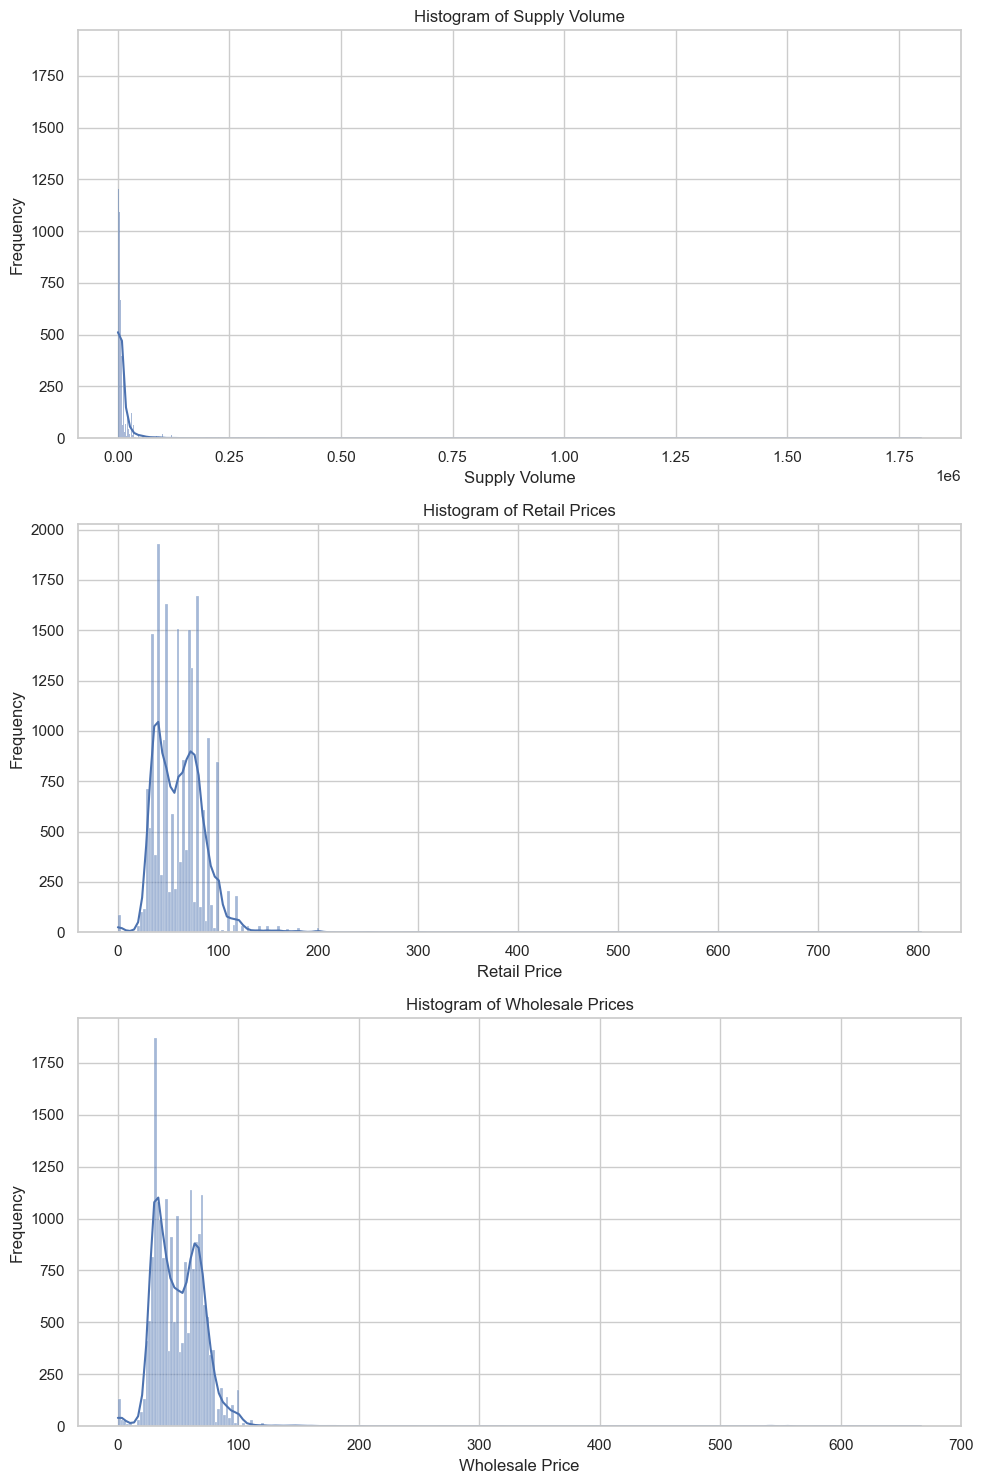

In [111]:
# Set the style for the plots
sns.set(style='whitegrid')

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram for Supply Volume
sns.histplot(data['Supply Volume'], bins= 'auto', kde=True, ax=axes[0])
axes[0].set_title('Histogram of Supply Volume')
axes[0].set_xlabel('Supply Volume')
axes[0].set_ylabel('Frequency')

# Histogram for Retail
sns.histplot(data['Retail'], bins= 'auto', kde=True, ax=axes[1])
axes[1].set_title('Histogram of Retail Prices')
axes[1].set_xlabel('Retail Price')
axes[1].set_ylabel('Frequency')

# Histogram for Wholesale
sns.histplot(data['Wholesale'], bins= 'auto', kde=True, ax=axes[2])
axes[2].set_title('Histogram of Wholesale Prices')
axes[2].set_xlabel('Wholesale Price')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


In [112]:
data.columns

Index(['Wholesale', 'Retail', 'Supply Volume', 'County', 'Date', 'Year',
       'Month', 'Day', 'DayOfWeek', 'Quarter', 'Month_sin', 'Month_cos',
       'Day_sin', 'Day_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Quarter_sin',
       'Quarter_cos', 'Year_sin', 'Year_cos', 'Wholesale_lag_7',
       'Retail_lag_7', 'Supply_Volume_lag_7', 'Wholesale_rolling_mean_7d',
       'Retail_rolling_mean_7d', 'Supply_Volume_rolling_mean_7d',
       'Wholesale_rolling_std_7d', 'Retail_rolling_std_7d',
       'Supply_Volume_rolling_std_7d', 'County_0', 'County_1', 'County_2',
       'County_3', 'County_4', 'County_5', 'Market_0', 'Market_1', 'Market_2',
       'Market_3', 'Market_4', 'Market_5', 'Market_6', 'Market_7',
       'Classification_0', 'Classification_1', 'Classification_2'],
      dtype='object')

# Data Visualization: Histograms of Supply Volume and Prices

## Overview
The following histograms illustrate the distributions of three key variables: **Supply Volume**, **Retail Prices**, and **Wholesale Prices**. These visualizations help us understand the underlying distributions and potential outliers in the dataset, which are crucial for subsequent analysis and modeling.

### Histograms
1. **Histogram of Supply Volume**
   - The distribution of the supply volume appears to be highly skewed, indicating that a significant portion of the data has low supply levels.
   - Understanding this distribution helps in determining how supply impacts pricing and overall market dynamics.


2. **Histogram of Retail Prices**
   - The retail prices also show a skewed distribution, with many low price points and fewer instances of higher prices.
   - Analyzing this distribution is vital for identifying pricing strategies and assessing market competition.



3. **Histogram of Wholesale Prices**
   - Similarly, the wholesale prices reflect a distribution that favors lower price points, indicating potential bulk pricing strategies.
   - Insights gained from this histogram can inform purchasing decisions and pricing models.

>

## Importance of Min-Max Scaling
To prepare the data for modeling, we will apply **Min-Max scaling**. This scaling technique is crucial for several reasons:

- **Normalization of Features**: By transforming the features to a range between 0 and 1, we ensure that all variables contribute equally to distance calculations in algorithms sensitive to feature scales (e.g., KNN, neural networks).
  
- **Improved Model Performance**: Many machine learning algorithms, including gradient descent-based models, converge faster when features are on a similar scale. This can lead to better performance and faster training times.

- **Enhanced Interpretability**: Scaled features can be easier to interpret, especially when comparing relative values across different datasets or models.

Applying a Min-Max scaler will enable us to create more robust predictive models and draw more reliable conclusions from our data analysis.


In [113]:

# # Define the columns to normalize (ignoring binary columns)
# columns_to_normalize = [
#     'Wholesale', 'Retail', 'Supply Volume',
#     'Wholesale_rolling_mean_7d', 'Retail_rolling_mean_7d',
#     'Supply_Volume_rolling_mean_7d', 'Wholesale_rolling_std_7d',
#     'Retail_rolling_std_7d', 'Supply_Volume_rolling_std_7d',
#     'Wholesale_lag_7', 'Retail_lag_7', 'Supply_Volume_lag_7',
#     'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter',
#     'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos',
#     'DayOfWeek_sin', 'DayOfWeek_cos', 'Quarter_sin', 'Quarter_cos',
#     'Year_sin', 'Year_cos'
# ]

# # Create a dictionary to hold the scalers
# scalers = {}

# # Loop through each column to apply scaling and store the scaler
# for column in columns_to_normalize:
#     # Creating a MinMaxScaler for normalization
#     scaler = MinMaxScaler()
    
#     # Fit the scaler on the current column
#     scaler.fit(data[[column]])
    
#     # Applying normalization to the current column
#     data[column] = scaler.transform(data[[column]])
    
#     # Store the scaler for inverse scaling later
#     scalers[column] = scaler

# # Ensure directory exists before saving the scalers
# scaler_file_path = 'models/scalers.pkl'
# os.makedirs(os.path.dirname(scaler_file_path), exist_ok=True)

# # Save the scalers dictionary to a file
# dump(scalers, scaler_file_path)

# # Display the first few rows of the dataframe after normalization
# print(data.head())


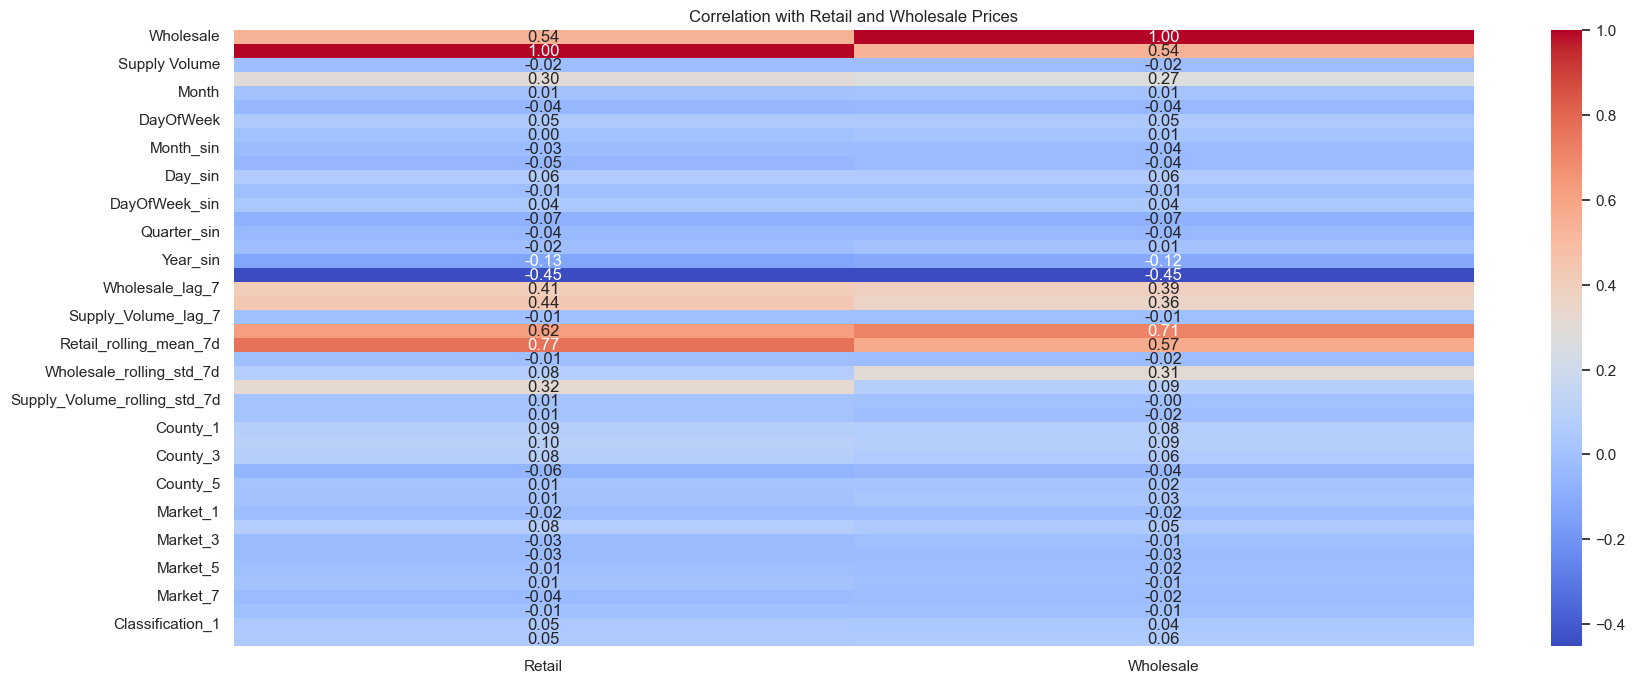

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Drop non-numeric columns (like 'County') to compute the correlation matrix
numeric_data = data.select_dtypes(include=[float, int])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Filter for correlations with Retail and Wholesale
correlation_with_target = correlation_matrix[['Retail', 'Wholesale']]

# Plotting the heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation with Retail and Wholesale Prices')
plt.show()



In [115]:
# Calculate the correlation matrix, excluding non-numeric columns like 'County'
correlation_matrix = data.select_dtypes(include='number').corr()

# Filter for correlations with Wholesale and Retail only
correlation_with_target = correlation_matrix[['Wholesale', 'Retail']]

# Display the result
print(correlation_with_target)


                               Wholesale    Retail
Wholesale                       1.000000  0.544515
Retail                          0.544515  1.000000
Supply Volume                  -0.021002 -0.016252
Year                            0.274391  0.298570
Month                           0.011105  0.005406
Day                            -0.041235 -0.043011
DayOfWeek                       0.049969  0.048100
Quarter                         0.014263  0.002309
Month_sin                      -0.036592 -0.031269
Month_cos                      -0.035907 -0.048475
Day_sin                         0.062676  0.063209
Day_cos                        -0.007790 -0.009004
DayOfWeek_sin                   0.038105  0.039634
DayOfWeek_cos                  -0.072486 -0.072610
Quarter_sin                    -0.040206 -0.041773
Quarter_cos                     0.006835 -0.015222
Year_sin                       -0.115440 -0.128266
Year_cos                       -0.448291 -0.450650
Wholesale_lag_7                

In [116]:
# Set a threshold for filtering
threshold = 0.1

# Filter out columns with absolute correlation greater than the threshold
filtered_columns = correlation_with_target[(correlation_with_target['Retail'].abs() > threshold) | 
                                           (correlation_with_target['Wholesale'].abs() > threshold)]

# Get the names of the filtered columns
filtered_column_names = filtered_columns.index.tolist()

# Ensure that 'Date' is part of the filtered columns
if 'Date' not in filtered_column_names:
    filtered_column_names.append('Date')

# Exclude the target columns (Retail and Wholesale) if necessary
filtered_column_names = [col for col in filtered_column_names if col not in ['Retail', 'Wholesale']]

# Display the filtered column names
print("Filtered columns based on correlation threshold:")
print(filtered_column_names)



Filtered columns based on correlation threshold:
['Year', 'Year_sin', 'Year_cos', 'Wholesale_lag_7', 'Retail_lag_7', 'Wholesale_rolling_mean_7d', 'Retail_rolling_mean_7d', 'Wholesale_rolling_std_7d', 'Retail_rolling_std_7d', 'County_2', 'Date']


In [117]:
final_modeling_data = data[filtered_column_names].copy()  # Use .copy() to avoid SettingWithCopyWarning
final_modeling_data = final_modeling_data.join(data[['Wholesale', 'Retail']])


In [118]:
final_modeling_data.head(20)

,Year,Year_sin,Year_cos,Wholesale_lag_7,Retail_lag_7,Wholesale_rolling_mean_7d,Retail_rolling_mean_7d,Wholesale_rolling_std_7d,Retail_rolling_std_7d,County_2,Date,Wholesale,Retail
5390,2021,0.000000,1.0,27.78,40.0,27.780000,40.000000,1.569777,0.000000,0,2021-05-24,27.78,40.0
5391,2021,0.000000,1.0,27.78,40.0,28.890000,40.000000,1.569777,0.000000,0,2021-05-24,30.00,40.0
5392,2021,0.000000,1.0,27.78,40.0,30.370000,40.000000,2.793439,0.000000,0,2021-05-24,33.33,40.0
5393,2021,0.000000,1.0,27.78,40.0,32.777500,41.250000,5.327891,2.500000,0,2021-11-30,40.00,45.0
5394,2022,0.866025,-0.5,27.78,40.0,35.222000,43.000000,7.153162,4.472136,0,2022-03-01,45.00,50.0
5395,2022,0.866025,-0.5,27.78,40.0,36.851667,44.166667,7.541158,4.915960,0,2022-03-08,45.00,50.0
5396,2022,0.866025,-0.5,27.78,40.0,38.015714,45.000000,7.541613,5.000000,0,2022-03-15,45.00,50.0
5397,2022,0.866025,-0.5,27.78,40.0,41.190000,47.142857,7.183038,5.669467,0,2022-03-29,50.00,55.0
5398,2022,0.866025,-0.5,30.00,40.0,44.761429,50.000000,6.901576,6.454972,0,2022-04-11,55.00,60.0
5399,2022,0.866025,-0.5,33.33,40.0,49.285714,54.285714,8.380817,8.380817,0,2022-05-04,65.00,70.0


In [119]:
len(final_modeling_data)

20431

In [120]:
final_modeling_data.isna().sum()

Year                         0
Year_sin                     0
Year_cos                     0
Wholesale_lag_7              0
Retail_lag_7                 0
Wholesale_rolling_mean_7d    0
Retail_rolling_mean_7d       0
Wholesale_rolling_std_7d     0
Retail_rolling_std_7d        0
County_2                     0
Date                         0
Wholesale                    0
Retail                       0
dtype: int64

In [121]:
final_modeling_data.to_csv("modeling_data_2.csv", index = False)

In [122]:
# Select the relevant columns from the data
columns_to_include = filtered_column_names + ['County']  # Add 'County' to the filtered columns

# Ensure that the dataframe contains only the selected columns
historical_data = data[columns_to_include]
historical_data = historical_data.join(data[['Wholesale', 'Retail']])



In [123]:
historical_data.columns

Index(['Year', 'Year_sin', 'Year_cos', 'Wholesale_lag_7', 'Retail_lag_7',
       'Wholesale_rolling_mean_7d', 'Retail_rolling_mean_7d',
       'Wholesale_rolling_std_7d', 'Retail_rolling_std_7d', 'County_2', 'Date',
       'County', 'Wholesale', 'Retail'],
      dtype='object')

In [124]:
# Group by 'County' and 'Date' to calculate the mean for 'Wholesale' and 'Retail'
daily_average_data = historical_data.groupby(['County', 'Date']).agg({
    'Wholesale': 'mean',
    'Retail': 'mean',
}).reset_index()

# Merge the daily averages back with the historical_data to maintain the original structure
historical_data_with_averages = historical_data.merge(daily_average_data, on=['County', 'Date'], suffixes=('', '_avg'))

# The resulting dataframe now has 'Wholesale_avg' and 'Retail_avg' columns representing the daily averages

# Save the resulting dataframe to a new CSV file
historical_data_with_averages.to_csv("historical_data.csv", index=False)

print("Filtered data with daily average per county saved to 'historical_data.csv'.")


Filtered data with daily average per county saved to 'historical_data.csv'.
